In [2]:
import re
import random
import time
import math
import numpy as np
import nltk
import matplotlib.pyplot as plt
plt.style.use('default')

In [ ]:
# !wget http://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip
# !unzip trainDevTestTrees_PTB.zip

--2025-12-09 10:33:08--  http://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip [following]
--2025-12-09 10:33:09--  https://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 789539 (771K) [application/zip]
Saving to: ‘trainDevTestTrees_PTB.zip’

trainDevTestTrees_P 100%[===================>] 771.03K  1.03MB/s    in 0.7s    

2025-12-09 10:33:09 (1.03 MB/s) - ‘trainDevTestTrees_PTB.zip’ saved [789539/789539]

Archive:  trainDevTestTrees_PTB.zip
   creating: trees/
  inflating: trees/dev.txt           
  inflating: trees/test.txt          
  inflating: trees/train.txt         


In [1]:
# this function reads in a textfile and fixes an issue with "\\"
def filereader(path):
  with open(path, mode="r", encoding="utf-8") as f:
    for line in f:
      yield line.strip().replace("\\","")

Let's look at a data point. It is a **flattened binary tree**, with sentiment scores at every node, and words as the leaves (or *terminal nodes*).

In [3]:
s = next(filereader("trees/dev.txt"))
print(s)

(3 (2 It) (4 (4 (2 's) (4 (3 (2 a) (4 (3 lovely) (2 film))) (3 (2 with) (4 (3 (3 lovely) (2 performances)) (2 (2 by) (2 (2 (2 Buy) (2 and)) (2 Accorsi))))))) (2 .)))


In [4]:
# We can use NLTK to better visualise the tree structure of the sentence
from nltk import Tree
from nltk.treeprettyprinter import TreePrettyPrinter
tree = Tree.fromstring(s)
print(TreePrettyPrinter(tree))

              3                                                                     
  ____________|____________________                                                  
 |                                 4                                                
 |        _________________________|______________________________________________   
 |       4                                                                        | 
 |    ___|______________                                                          |  
 |   |                  4                                                         | 
 |   |         _________|__________                                               |  
 |   |        |                    3                                              | 
 |   |        |               _____|______________________                        |  
 |   |        |              |                            4                       | 
 |   |        |              |            ________________|_

/var/folders/m5/wwbxgfjj3g7bn2wdsmlw55j80000gn/T/ipykernel_73089/348436308.py:5: DeprecationWarning: 
    Class TreePrettyPrinter has been deprecated.  Import
    `TreePrettyPrinter` using `from nltk.tree import
    TreePrettyPrinter` instead.
  print(TreePrettyPrinter(tree))


The sentiment scores range from 0 (very negative) to 5 (very positive). Again, as you can see, every node in the tree is labeled with a sentiment score. For now, we will only use the score at the **root node**, i.e., the sentiment score for the complete sentence.

In [5]:
# Let's first make a function that extracts the tokens (the leaves).

def tokens_from_treestring(s):
  """extract the tokens from a sentiment tree"""
  return re.sub(r"\([0-9] |\)", "", s).split()

# let's try it on our example tree
tokens = tokens_from_treestring(s)
print(tokens)
print(len(tokens))

['It', "'s", 'a', 'lovely', 'film', 'with', 'lovely', 'performances', 'by', 'Buy', 'and', 'Accorsi', '.']
13


> *Warning: you could also parse a treestring using NLTK and ask it to return the leaves, but there seems to be an issue with NLTK not always correctly parsing the input, so do not rely on it.*

In [6]:
# We will also need the following function, but you can ignore this for now.
# It is explained later on.

SHIFT = 0
REDUCE = 1


def transitions_from_treestring(s):
  s = re.sub("\([0-5] ([^)]+)\)", "0", s)
  s = re.sub("\)", " )", s)
  s = re.sub("\([0-4] ", "", s)
  s = re.sub("\([0-4] ", "", s)
  s = re.sub("\)", "1", s)
  return list(map(int, s.split()))

<>:9: SyntaxWarning: invalid escape sequence '\('
<>:10: SyntaxWarning: invalid escape sequence '\)'
<>:11: SyntaxWarning: invalid escape sequence '\('
<>:12: SyntaxWarning: invalid escape sequence '\('
<>:13: SyntaxWarning: invalid escape sequence '\)'
<>:9: SyntaxWarning: invalid escape sequence '\('
<>:10: SyntaxWarning: invalid escape sequence '\)'
<>:11: SyntaxWarning: invalid escape sequence '\('
<>:12: SyntaxWarning: invalid escape sequence '\('
<>:13: SyntaxWarning: invalid escape sequence '\)'
/var/folders/m5/wwbxgfjj3g7bn2wdsmlw55j80000gn/T/ipykernel_73089/1625531552.py:9: SyntaxWarning: invalid escape sequence '\('
  s = re.sub("\([0-5] ([^)]+)\)", "0", s)
/var/folders/m5/wwbxgfjj3g7bn2wdsmlw55j80000gn/T/ipykernel_73089/1625531552.py:10: SyntaxWarning: invalid escape sequence '\)'
  s = re.sub("\)", " )", s)
/var/folders/m5/wwbxgfjj3g7bn2wdsmlw55j80000gn/T/ipykernel_73089/1625531552.py:11: SyntaxWarning: invalid escape sequence '\('
  s = re.sub("\([0-4] ", "", s)
/var/folde

In [7]:
# Now let's first see how large our data sets are.
for path in ("trees/train.txt", "trees/dev.txt", "trees/test.txt"):
  print("{:16s} {:4d}".format(path, sum(1 for _ in filereader(path))))

trees/train.txt  8544
trees/dev.txt    1101
trees/test.txt   2210


You can see that the number of sentences is not very large. That's probably because the data set required so much manual annotation. However, it is large enough to train a neural network on.

It will be useful to store each data example in an `Example` object,
containing everything that we may need for each data point.
It will contain the tokens, the tree, the top-level sentiment label, and
the transitions (explained later).

In [8]:
from collections import namedtuple
from nltk import Tree

# A simple way to define a class is using namedtuple.
Example = namedtuple("Example", ["tokens", "tree", "label", "transitions"])


def examplereader(path, lower=False):
  """Returns all examples in a file one by one."""
  for line in filereader(path):
    line = line.lower() if lower else line
    tokens = tokens_from_treestring(line)
    tree = Tree.fromstring(line)  # use NLTK's Tree
    label = int(line[1])
    trans = transitions_from_treestring(line)
    yield Example(tokens=tokens, tree=tree, label=label, transitions=trans)


# Let's load the data into memory.
LOWER = False  # we will keep the original casing
train_data = list(examplereader("trees/train.txt", lower=LOWER))
dev_data = list(examplereader("trees/dev.txt", lower=LOWER))
test_data = list(examplereader("trees/test.txt", lower=LOWER))

print("train", len(train_data))
print("dev", len(dev_data))
print("test", len(test_data))

train 8544
dev 1101
test 2210


Let's check out an `Example` object.

In [9]:
# Here we first define a class that can map a word to an ID (w2i)
# and back (i2w).

from collections import Counter, OrderedDict, defaultdict


class OrderedCounter(Counter, OrderedDict):
  """Counter that remembers the order elements are first seen"""
  def __repr__(self):
    return '%s(%r)' % (self.__class__.__name__,
                      OrderedDict(self))
  def __reduce__(self):
    return self.__class__, (OrderedDict(self),)


class Vocabulary:
  """A vocabulary, assigns IDs to tokens"""

  def __init__(self):
    self.freqs = OrderedCounter()
    self.w2i = {}
    self.i2w = []

  def count_token(self, t):
    self.freqs[t] += 1

  def add_token(self, t):
    self.w2i[t] = len(self.w2i)
    self.i2w.append(t)

  def build(self, min_freq=0):
    '''
    min_freq: minimum number of occurrences for a word to be included
              in the vocabulary
    '''
    self.add_token("<unk>")  # reserve 0 for <unk> (unknown words)
    self.add_token("<pad>")  # reserve 1 for <pad> (discussed later)

    tok_freq = list(self.freqs.items())
    tok_freq.sort(key=lambda x: x[1], reverse=True)
    for tok, freq in tok_freq:
      if freq >= min_freq:
        self.add_token(tok)

The vocabulary has by default an `<unk>` token and a `<pad>` token. The `<unk>` token is reserved for all words which do not appear in the training data (and for which, therefore, we cannot learn word representations). The function of the `<pad>` token will be explained later.


Let's build the vocabulary!


In [10]:
# This process should be deterministic and should have the same result
# if run multiple times on the same data set.

v = Vocabulary()
for data_set in (train_data,):
  for ex in data_set:
    for token in ex.tokens:
      v.count_token(token)

v.build()
print("Vocabulary size:", len(v.w2i))

Vocabulary size: 18280


Let's have a closer look at the properties of our vocabulary. Having a good idea of what it is like can facilitate data analysis and debugging later on.

In [11]:
# Now let's map the sentiment labels 0-4 to a more readable form
i2t = ["very negative", "negative", "neutral", "positive", "very positive"]
print(i2t)
print(i2t[4])

['very negative', 'negative', 'neutral', 'positive', 'very positive']
very positive


In [12]:
# And let's also create the opposite mapping.
# We won't use a Vocabulary for this (although we could), since the labels
# are already numeric.
t2i = OrderedDict({p : i for p, i in zip(i2t, range(len(i2t)))})
print(t2i)
print(t2i['very positive'])

OrderedDict({'very negative': 0, 'negative': 1, 'neutral': 2, 'positive': 3, 'very positive': 4})
4


## PyTorch

We are going to need PyTorch and Google Colab does not have it installed by default. Run the cell below to install it.

*For installing PyTorch in your own computer, follow the instructions on [pytorch.org](pytorch.org) instead. This is for Google Colab only.*

In [13]:
import torch
print("Using torch", torch.__version__)

Using torch 2.6.0


In [14]:
# Let's also import torch.nn, a PyTorch package that
# makes building neural networks more convenient.
from torch import nn

In [15]:
# PyTorch can run on CPU or on Nvidia GPU (video card) using CUDA
# This cell selects the GPU if one is available.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [16]:
# Seed manually to make runs reproducible
# You need to set this again if you do multiple runs of the same model
torch.manual_seed(42)

# When running on the CuDNN backend two further options must be set for reproducibility
if torch.cuda.is_available():
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

# BOW

In [17]:
# Here we print each parameter name, shape, and if it is trainable.
def print_parameters(model):
  total = 0
  for name, p in model.named_parameters():
    total += np.prod(p.shape)
    print("{:24s} {:12s} requires_grad={}".format(name, str(list(p.shape)), p.requires_grad))
  print("\nTotal number of parameters: {}\n".format(total))


#print_parameters(bow_model)

In [18]:
def prepare_example(example, vocab):
  """
  Map tokens to their IDs for a single example
  """

  # vocab returns 0 if the word is not there (i2w[0] = <unk>)
  x = [vocab.w2i.get(t, 0) for t in example.tokens]

  x = torch.LongTensor([x])
  x = x.to(device)

  y = torch.LongTensor([example.label])
  y = y.to(device)

  return x, y

In [19]:
def simple_evaluate(model, data, prep_fn=prepare_example, **kwargs):
  """Accuracy of a model on given data set."""
  correct = 0
  total = 0
  model.eval()  # disable dropout (explained later)

  for example in data:

    # convert the example input and label to PyTorch tensors
    x, target = prep_fn(example, model.vocab)

    # forward pass without backpropagation (no_grad)
    # get the output from the neural network for input x
    with torch.no_grad():
      logits = model(x)

    # get the prediction
    prediction = logits.argmax(dim=-1)

    # add the number of correct predictions to the total correct
    correct += (prediction == target).sum().item()
    total += 1

  return correct, total, correct / float(total)

We are using accuracy as a handy evaluation metric. Please consider using [alternative metrics](https://scikit-learn.org/stable/modules/classes.html#classification-metrics) for your experiments if that makes more theoretical sense.

#### Example feed
For stochastic gradient descent (SGD) we will need a random training example for every update.
We implement this by shuffling the training data and returning examples one by one using `yield`.

Shuffling is optional so that we get to use this function to get validation and test examples, too.

In [20]:
def get_examples(data, shuffle=True, **kwargs):
  """Shuffle data set and return 1 example at a time (until nothing left)"""
  if shuffle:
    print("Shuffling training data")
    random.shuffle(data)  # shuffle training data each epoch
  for example in data:
    yield example

#### Exercise: Training function

Your task is now to complete the training loop below.
Before you do so, please read the section about optimisation.

In [21]:
from torch import optim

In [22]:
def train_model(model, optimizer, num_iterations=10000,
                print_every=1000, eval_every=1000,
                batch_fn=get_examples,
                prep_fn=prepare_example,
                eval_fn=simple_evaluate,
                batch_size=1, eval_batch_size=None):
  """Train a model."""
  iter_i = 0
  train_loss = 0.
  print_num = 0
  start = time.time()
  criterion = nn.CrossEntropyLoss() # loss function
  best_eval = 0.
  best_iter = 0

  # store train loss and validation accuracy during training
  # so we can plot them afterwards
  losses = []
  accuracies = []

  if eval_batch_size is None:
    eval_batch_size = batch_size

  while True:  # when we run out of examples, shuffle and continue
    for batch in batch_fn(train_data, batch_size=batch_size):

      # forward pass
      model.train()
      x, targets = prep_fn(batch, model.vocab)
      logits = model(x)

      B = targets.size(0)  # later we will use B examples per update

      # compute cross-entropy loss (our criterion)
      # note that the cross entropy loss function computes the softmax for us
      loss = criterion(logits.view([B, -1]), targets.view(-1))
      train_loss += loss.item()

      # backward pass (tip: check the Introduction to PyTorch notebook)

      # ========== MY CODE ==============
      # erase previous gradients
      optimizer.zero_grad()

      # compute gradients
      loss.backward()

      # update weights - take a small step in the opposite dir of the gradient
      optimizer.step()

      print_num += 1
      iter_i += 1

      # print info
      if iter_i % print_every == 0:
        print("Iter %r: loss=%.4f, time=%.2fs" %
              (iter_i, train_loss, time.time()-start))
        losses.append(train_loss)
        print_num = 0
        train_loss = 0.

      # evaluate
      if iter_i % eval_every == 0:
        _, _, accuracy = eval_fn(model, dev_data, batch_size=eval_batch_size,
                                 batch_fn=batch_fn, prep_fn=prep_fn)
        accuracies.append(accuracy)
        print("iter %r: dev acc=%.4f" % (iter_i, accuracy))

        # save best model parameters
        if accuracy > best_eval:
          print("new highscore")
          best_eval = accuracy
          best_iter = iter_i
          path = "{}.pt".format(model.__class__.__name__)
          ckpt = {
              "state_dict": model.state_dict(),
              "optimizer_state_dict": optimizer.state_dict(),
              "best_eval": best_eval,
              "best_iter": best_iter
          }
          torch.save(ckpt, path)

      # done training
      if iter_i == num_iterations:
        print("Done training")

        # evaluate on train, dev, and test with best model
        print("Loading best model")
        path = "{}.pt".format(model.__class__.__name__)
        ckpt = torch.load(path)
        model.load_state_dict(ckpt["state_dict"])

        _, _, train_acc = eval_fn(
            model, train_data, batch_size=eval_batch_size,
            batch_fn=batch_fn, prep_fn=prep_fn)
        _, _, dev_acc = eval_fn(
            model, dev_data, batch_size=eval_batch_size,
            batch_fn=batch_fn, prep_fn=prep_fn)
        _, _, test_acc = eval_fn(
            model, test_data, batch_size=eval_batch_size,
            batch_fn=batch_fn, prep_fn=prep_fn)

        print("best model iter {:d}: "
              "train acc={:.4f}, dev acc={:.4f}, test acc={:.4f}".format(
                  best_iter, train_acc, dev_acc, test_acc))

        return losses, accuracies

In [23]:
def train_model_w_subtree(model, optimizer, num_iterations=10000,
                          print_every=1000, eval_every=1000,
                          batch_fn=get_examples,
                          prep_fn=prepare_example,
                          eval_fn=simple_evaluate,
                          batch_size=1, eval_batch_size=None):
    """Train a model with subtree supervision."""
    iter_i = 0
    train_loss = 0.
    start = time.time()
    criterion = nn.CrossEntropyLoss()  # loss function
    best_eval = 0.
    best_iter = 0

    losses = []
    accuracies = []

    if eval_batch_size is None:
        eval_batch_size = batch_size

    while True:
        for batch in batch_fn(train_data, batch_size=batch_size):
            model.train()

            # --- prepare inputs ---
            # prep_fn should now return subtree labels as well
            (x, transitions), targets, subtree_labels = prep_fn(batch, model.vocab)
            root_logits, subtree_logits = model((x, transitions))

            B = targets.size(0)

            # --- compute root loss ---
            loss_root = criterion(root_logits, targets)

            # --- compute subtree loss ---
            flat_subtree_logits = []
            flat_subtree_labels = []

            for b, sent_nodes in enumerate(subtree_logits):
                for i, node_logit in enumerate(sent_nodes):
                    flat_subtree_logits.append(node_logit)
                    flat_subtree_labels.append(subtree_labels[b][i])

            # flat_subtree_logits = torch.stack(flat_subtree_logits, dim=0)
            # flat_subtree_labels = [int(lbl) for lbl in flat_subtree_labels]
            # flat_subtree_labels = torch.tensor(flat_subtree_labels, device=flat_subtree_logits.device)

            # flat_subtree_logits: [total_nodes, num_classes]
            flat_subtree_logits = torch.stack(flat_subtree_logits, dim=0)
            flat_subtree_logits = flat_subtree_logits.squeeze(1)  # [N, C]

            # flat_subtree_labels: [total_nodes], as integers
            flat_subtree_labels = torch.tensor([int(lbl) for lbl in flat_subtree_labels],
                                              dtype=torch.long, device=flat_subtree_logits.device)

            #print(f"flat_subtree_logits : {flat_subtree_logits.size()}")
            #print(f"flat_subtree_labels : {flat_subtree_labels.size()}")
            loss_subtree = criterion(flat_subtree_logits, flat_subtree_labels)

            # combine losses (you can weight them if desired)
            loss = loss_root + loss_subtree
            train_loss += loss.item()

            # --- backward pass ---
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            iter_i += 1

            # --- printing and evaluation ---
            if iter_i % print_every == 0:
                print(f"Iter {iter_i}: loss={train_loss:.4f}, time={time.time()-start:.2f}s")
                losses.append(train_loss)
                train_loss = 0.

            if iter_i % eval_every == 0:
                _, _, accuracy = eval_fn(model, dev_data, batch_size=eval_batch_size,
                                         batch_fn=batch_fn, prep_fn=prep_fn)
                accuracies.append(accuracy)
                print(f"Iter {iter_i}: dev acc={accuracy:.4f}")

                if accuracy > best_eval:
                    print("New highscore!")
                    best_eval = accuracy
                    best_iter = iter_i
                    path = f"{model.__class__.__name__}.pt"
                    ckpt = {
                        "state_dict": model.state_dict(),
                        "optimizer_state_dict": optimizer.state_dict(),
                        "best_eval": best_eval,
                        "best_iter": best_iter
                    }
                    torch.save(ckpt, path)

            if iter_i == num_iterations:
                print("Done training")

                # load best model for final evaluation
                path = f"{model.__class__.__name__}.pt"
                ckpt = torch.load(path)
                model.load_state_dict(ckpt["state_dict"])

                _, _, train_acc = eval_fn(model, train_data, batch_size=eval_batch_size,
                                          batch_fn=batch_fn, prep_fn=prep_fn)
                _, _, dev_acc = eval_fn(model, dev_data, batch_size=eval_batch_size,
                                        batch_fn=batch_fn, prep_fn=prep_fn)
                _, _, test_acc = eval_fn(model, test_data, batch_size=eval_batch_size,
                                         batch_fn=batch_fn, prep_fn=prep_fn)

                print(f"Best model iter {best_iter}: "
                      f"train acc={train_acc:.4f}, dev acc={dev_acc:.4f}, test acc={test_acc:.4f}")
                return losses, accuracies


### Training the BOW model

# Pre-trained word embeddings

The Stanford Sentiment Treebank is a rather small data set, since it required fine-grained manual annotatation. This makes it difficult for the Deep CBOW model to learn good word embeddings, i.e. to learn good word representations for the words in our vocabulary.
In fact, the only error signal that the network receives is from predicting the sentiment of entire sentences!

To start off with better word representations, we can download **pre-trained word embeddings**.
You can choose which pre-trained word embeddings to use:

- **GloVe**. The "original" Stanford Sentiment classification [paper](http://aclweb.org/anthology/P/P15/P15-1150.pdf) used Glove embeddings, which are just another method (like *word2vec*) to get word embeddings from unannotated text. Glove is described in the following paper which you should cite if you use them:
> Jeffrey Pennington, Richard Socher, and Christopher Manning. ["Glove: Global vectors for word representation."](https://nlp.stanford.edu/pubs/glove.pdf) EMNLP 2014.

- **Word2Vec**. This is the method that you learned about in class, described in:
> Mikolov, Tomas, et al. ["Distributed representations of words and phrases and their compositionality."](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) Advances in neural information processing systems. 2013.

Using these pre-trained word embeddings, we can initialize our word embedding lookup table and start form a point where similar words are already close to one another in the distributional semantic space.

You can choose to keep the word embeddings **fixed** or to train them further, specialising them to the task at hand.
We will keep them fixed for now.

For the purposes of this lab, it is enough if you understand how word2vec works (whichever vectors you use), but if you are interested, we encourage you to also check out the GloVe paper.

You can either download the word2vec vectors, or the Glove vectors.
If you want to compare your results to the Stanford paper later on, then you should use Glove.
**At the end of this lab you have the option to compare which vectors give you the best performance. For now, simply choose one of them and continue with that.**

[**OPTIONAL in case you don't want to mount Google Drive:** instead of running all the 5 boxes below, you can 1) download the GloVe and word2vec in your local machine, 2) upload them on your Drive folder ("My Drive"). Then, uncomment the first 2 lines in box 6 before writing your code!]


In [ ]:
# This downloads the Glove 840B 300d embeddings.
# The original file is at http://nlp.stanford.edu/data/glove.840B.300d.zip
# Since that file is 2GB, we provide you with a *filtered version*
# which contains all the words you need for this data set.

# You only need to do this once.
# Please comment this cell out after downloading.

#!wget https://gist.githubusercontent.com/bastings/b094de2813da58056a05e8e7950d4ad1/raw/3fbd3976199c2b88de2ae62afc0ecc6f15e6f7ce/glove.840B.300d.sst.txt

In [ ]:
# This downloads the word2vec 300D Google News vectors
# The file has been truncated to only contain words that appear in our data set.
# You can find the original file here: https://code.google.com/archive/p/word2vec/

# You only need to do this once.
# Please comment this out after downloading.
#!wget https://gist.githubusercontent.com/bastings/4d1c346c68969b95f2c34cfbc00ba0a0/raw/76b4fefc9ef635a79d0d8002522543bc53ca2683/googlenews.word2vec.300d.txt

In [ ]:
# Mount Google Drive (to save the downloaded files)
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# Copy word vectors *to* Google Drive

# You only need to do this once.
# Please comment this out after running it.
# !cp "glove.840B.300d.sst.txt" "/gdrive/My Drive/"
# !cp "googlenews.word2vec.300d.txt" "/gdrive/My Drive/"

In [ ]:
# If you copied the word vectors to your Drive before,
# here is where you copy them back to the Colab notebook.

# Copy Glove vectors *from* Google Drive
# !cp "/gdrive/My Drive/glove.840B.300d.sst.txt" .
# !cp "/gdrive/My Drive/googlenews.word2vec.300d.txt" .

In [ ]:
# Uncomment these 2 lines below if went for the OPTIONAL method described above
# !cp "glove.840B.300d.sst.txt" "./"
# !cp "googlenews.word2vec.300d.txt" "./"

In [25]:
import os

In [63]:
# --- 1. Download the Word2Vec file (Replaces !wget) ---
# Check if the file already exists to avoid re-downloading
url = "https://gist.githubusercontent.com/bastings/4d1c346c68969b95f2c34cfbc00ba0a0/raw/76b4fefc9ef635a79d0d8002522543bc53ca2683/googlenews.word2vec.300d.txt"
filename = "googlenews.word2vec.300d.txt"

if not os.path.exists(filename):
    print(f"Downloading {filename}...")
    try:
        urllib.request.urlretrieve(url, filename)
        print("Download complete.")
    except Exception as e:
        print(f"Error during download: {e}")
else:
    print(f"File '{filename}' already exists. Skipping download.")

File 'googlenews.word2vec.300d.txt' already exists. Skipping download.


At this point you have the pre-trained word embedding files, but what do they look like?

In [76]:
# --- 2. Read and Process the Word Vectors (Replaces file access from Google Drive) ---
# On your local machine, the file is in the current working directory,
# so you can open it directly by its name.

word2vec_data = {}
lines_to_print = 4

print(f"\nProcessing file and printing first {lines_to_print} lines:")
try:
    with open(filename, encoding="utf-8") as input_file:
      i = 0
      for line in input_file:
        # Printing the first 4 lines as requested
        if i < lines_to_print:
          print(f"Line {i+1}: {line.strip()}")
          # To check the vector length (skip first word/token)
          print(f"Vector Length: {len(line.split()[1:])}\n")
        
        # Converting to a dictionary format
        line_parts = line.split()
        if line_parts: # Ensure the line is not empty
          word = line_parts[0]
          # Convert the rest of the parts (the vector) to numpy float32
          vector = [np.float32(x) for x in line_parts[1:]]
          word2vec_data[word] = vector
        
        i += 1
        
        # Optional: Stop after a few lines for testing to save memory/time
        # if i > 1000: 
        #    break 
        
    print(f"\nSuccessfully loaded {len(word2vec_data)} vectors into the dictionary.")

except FileNotFoundError:
    print(f"\nERROR: The file '{filename}' was not found. Please check if the download was successful.")
except Exception as e:
    print(f"\nAn error occurred while reading the file: {e}")


Processing file and printing first 4 lines:
Line 1: in 0.0703125 0.08691406 0.087890625 0.0625 0.06933594 -0.10888672 -0.08154297 -0.15429688 0.020751953 0.13183594 -0.11376953 -0.037353516 0.06933594 0.078125 -0.103027344 -0.09765625 0.044189453 0.10253906 -0.060791016 -0.036132812 -0.045410156 0.04736328 -0.12060547 -0.063964844 0.0022583008 0.037109375 -0.0029144287 0.11767578 0.061767578 0.063964844 0.08105469 -0.068847656 -0.021362305 0.05517578 -0.08544922 0.068847656 -0.12792969 -0.033203125 0.09863281 0.17578125 0.110839844 -0.03466797 -0.04711914 -0.008483887 0.035888672 0.103027344 0.026977539 -0.028686523 -0.005126953 0.10644531 0.059814453 0.09423828 0.033691406 -0.02709961 -0.09423828 0.0010299683 -0.048339844 0.034423828 0.08105469 -0.11328125 -0.08886719 0.035888672 -0.14550781 -0.24414062 -0.061523438 0.052978516 0.056884766 0.1796875 0.061035156 0.08691406 0.12402344 -0.040283203 0.022583008 0.17773438 -0.029663086 -0.029663086 0.1171875 0.03112793 -0.096191406 0.0664

In [77]:
# YOUR CODE HERE
word2vec_vocab = Vocabulary()
vectors = []

# taking the embedding dimension for the word2vec words
embedding_dim = 300 #len(word2vec_data.values()[0]) # recheck
print(f'our embed dim is {embedding_dim}')
# creating a tensor with values distributed based on the normal distribution with mean 0 and variance 1
# this is because for the unkown case we should be giving the embedding a
# somewhat realistic distribution to an actual word
# unk_vector = torch.randn(embedding_dim)
unk_vector = np.random.randn(embedding_dim)
vectors.append(unk_vector)
word2vec_vocab.add_token('<unk>')
# for padding, however, we do not want the embedding values to distort the
# meaning of our sentence. Hence, it is better to apply zero-padding.
pad_vector = np.zeros(embedding_dim)
vectors.append(pad_vector)

word2vec_vocab.add_token('<pad>')

for token, embedding in word2vec_data.items():
  #print(token)
  #print(embedding)
  word2vec_vocab.add_token(token)
  vectors.append(np.array(embedding))
  #break

#word2vec_vocab.build()
print("Vocabulary size:", len(word2vec_vocab.w2i))
print(embedding_dim)
vectors = np.stack(vectors, axis=0) 

our embed dim is 300
Vocabulary size: 18922
300


#### Exercise: words not in our pre-trained set

How many words in the training, dev, and test set are also in your vector set?
How many words are not there?

Store the words that are not in the word vector set in the set below.

#### Exercise: Finish the LSTM cell below.
You will need to implement the LSTM formulas:

$$
\begin{array}{ll}
        i = \sigma(W_{ii} x + b_{ii} + W_{hi} h + b_{hi}) \\
        f = \sigma(W_{if} x + b_{if} + W_{hf} h + b_{hf}) \\
        g = \tanh(W_{ig} x + b_{ig} + W_{hg} h + b_{hg}) \\
        o = \sigma(W_{io} x + b_{io} + W_{ho} h + b_{ho}) \\
        c' = f * c + i * g \\
        h' = o \tanh(c') \\
\end{array}
 $$

where $\sigma$ is the sigmoid function.

*Note that the LSTM formulas can differ slightly between different papers. We use the PyTorch LSTM formulation here.*

In [ ]:
class MyLSTMCell(nn.Module):
  """Our own LSTM cell"""

  def __init__(self, input_size, hidden_size, bias=True):
    """Creates the weights for this LSTM"""
    super(MyLSTMCell, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias

    # YOUR CODE HERE
    self.W_ii = torch.nn.Parameter(torch.Tensor(input_size, hidden_size))
    self.W_if = torch.nn.Parameter(torch.Tensor(input_size, hidden_size))
    self.W_ig = torch.nn.Parameter(torch.Tensor(input_size, hidden_size))
    self.W_io = torch.nn.Parameter(torch.Tensor(input_size, hidden_size))
    self.W_hi = torch.nn.Parameter(torch.Tensor(hidden_size, hidden_size))
    self.W_hf = torch.nn.Parameter(torch.Tensor(hidden_size, hidden_size))
    self.W_hg = torch.nn.Parameter(torch.Tensor(hidden_size, hidden_size))
    self.W_ho = torch.nn.Parameter(torch.Tensor(hidden_size, hidden_size))
    self.b_ii = torch.nn.Parameter(torch.Tensor(hidden_size))
    self.b_if = torch.nn.Parameter(torch.Tensor(hidden_size))
    self.b_ig = torch.nn.Parameter(torch.Tensor(hidden_size))
    self.b_io = torch.nn.Parameter(torch.Tensor(hidden_size))
    self.b_hi = torch.nn.Parameter(torch.Tensor(hidden_size))
    self.b_hf = torch.nn.Parameter(torch.Tensor(hidden_size))
    self.b_hg = torch.nn.Parameter(torch.Tensor(hidden_size))
    self.b_ho = torch.nn.Parameter(torch.Tensor(hidden_size))
    # end of my code

    self.reset_parameters()

  def reset_parameters(self):
    """This is PyTorch's default initialization method"""
    stdv = 1.0 / math.sqrt(self.hidden_size)
    for weight in self.parameters():
      weight.data.uniform_(-stdv, stdv)

  def forward(self, input_, hx, mask=None):
    """
    input is (batch, input_size)
    hx is ((batch, hidden_size), (batch, hidden_size))
    """
    prev_h, prev_c = hx

    # project input and prev state
    # YOUR CODE HERE

    i = torch.sigmoid(torch.matmul(input_, self.W_ii) + self.b_ii + torch.matmul(prev_h, self.W_hi) + self.b_hi)

    #raise NotImplementedError("Implement this")

    # main LSTM computation

    # i = ...
    f = torch.sigmoid(torch.matmul(input_, self.W_if) + self.b_if + torch.matmul(prev_h, self.W_hf) + self.b_hf)
    g = torch.tanh(torch.matmul(input_, self.W_ig) + self.b_ig + torch.matmul(prev_h, self.W_hg) + self.b_hg)
    o = torch.sigmoid(torch.matmul(input_, self.W_io) + self.b_io + torch.matmul(prev_h, self.W_ho) + self.b_ho)
    c = f * prev_c + i * g
    h = o * torch.tanh(c)

    return h, c

  def __repr__(self):
    return "{}({:d}, {:d})".format(
        self.__class__.__name__, self.input_size, self.hidden_size)

In [ ]:
class LSTMClassifier(nn.Module):
  """Encodes sentence with an LSTM and projects final hidden state"""

  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, vocab):
    super(LSTMClassifier, self).__init__()
    self.vocab = vocab
    self.hidden_dim = hidden_dim
    self.embed = nn.Embedding(vocab_size, embedding_dim, padding_idx=1)
    self.rnn = MyLSTMCell(embedding_dim, hidden_dim)

    self.output_layer = nn.Sequential(
        nn.Dropout(p=0.5),  # explained later
        nn.Linear(hidden_dim, output_dim)
    )

  def forward(self, x):

    B = x.size(0)  # batch size (this is 1 for now, i.e. 1 single example)
    T = x.size(1)  # timesteps (the number of words in the sentence)

    input_ = self.embed(x)

    # here we create initial hidden states containing zeros
    # we use a trick here so that, if input is on the GPU, then so are hx and cx
    hx = input_.new_zeros(B, self.rnn.hidden_size)
    cx = input_.new_zeros(B, self.rnn.hidden_size)

    # process input sentences one word/timestep at a time
    # input is batch-major (i.e., batch size is the first dimension)
    # so the first word(s) is (are) input_[:, 0]
    outputs = []
    for i in range(T):
      hx, cx = self.rnn(input_[:, i], (hx, cx))
      outputs.append(hx)

    # if we have a single example, our final LSTM state is the last hx
    if B == 1:
      final = hx
    else:
      #
      # This part is explained in next section, ignore this else-block for now.
      #
      # We processed sentences with different lengths, so some of the sentences
      # had already finished and we have been adding padding inputs to hx.
      # We select the final state based on the length of each sentence.

      # two lines below not needed if using LSTM from pytorch
      outputs = torch.stack(outputs, dim=0)           # [T, B, D]
      outputs = outputs.transpose(0, 1).contiguous()  # [B, T, D]

      # to be super-sure we're not accidentally indexing the wrong state
      # we zero out positions that are invalid
      pad_positions = (x == 1).unsqueeze(-1)

      outputs = outputs.contiguous()
      outputs = outputs.masked_fill_(pad_positions, 0.)

      mask = (x != 1)  # true for valid positions [B, T]
      lengths = mask.sum(dim=1)                 # [B, 1]

      indexes = (lengths - 1) + torch.arange(B, device=x.device, dtype=x.dtype) * T
      final = outputs.view(-1, self.hidden_dim)[indexes]  # [B, D]

    # we use the last hidden state to classify the sentence
    logits = self.output_layer(final)
    return logits

In [ ]:

# lstm_model = LSTMClassifier(len(word2vec_vocab.w2i), 300, 168, len(t2i), word2vec_vocab)

# # copy pre-trained word vectors into embeddings table
# with torch.no_grad():
#   lstm_model.embed.weight.data.copy_(torch.from_numpy(vectors))
#   lstm_model.embed.weight.requires_grad = False

# print(lstm_model)
# print_parameters(lstm_model)

# lstm_model = lstm_model.to(device)
# optimizer = optim.Adam(lstm_model.parameters(), lr=3e-4)

# lstm_losses, lstm_accuracies = train_model(
#     lstm_model, optimizer, num_iterations=25000,
#     print_every=250, eval_every=1000)

In [30]:
def get_minibatch(data, batch_size=25, shuffle=True):
  """Return minibatches, optional shuffling"""

  if shuffle:
    print("Shuffling training data")
    random.shuffle(data)  # shuffle training data each epoch

  batch = []

  # yield minibatches
  for example in data:
    batch.append(example)

    if len(batch) == batch_size:
      yield batch
      batch = []

  # in case there is something left
  if len(batch) > 0:
    yield batch

#### Padding function
We will need a function that adds padding 1s to a sequence of IDs so that
it becomes as long as the longest sequence in the minibatch.

In [31]:
def pad(tokens, length, pad_value=1):
  """add padding 1s to a sequence to that it has the desired length"""
  return tokens + [pad_value] * (length - len(tokens))

# example
tokens = [2, 3, 4]
pad(tokens, 5)

[2, 3, 4, 1, 1]

#### New `prepare` function

We will also need a new function that turns a mini-batch into PyTorch tensors.

In [32]:
def prepare_minibatch(mb, vocab):
  """
  Minibatch is a list of examples.
  This function converts words to IDs and returns
  torch tensors to be used as input/targets.
  """
  batch_size = len(mb)
  maxlen = max([len(ex.tokens) for ex in mb])

  # vocab returns 0 if the word is not there
  x = [pad([vocab.w2i.get(t, 0) for t in ex.tokens], maxlen) for ex in mb]

  x = torch.LongTensor(x)
  x = x.to(device)

  y = [ex.label for ex in mb]
  y = torch.LongTensor(y)
  y = y.to(device)

  return x, y

In [ ]:
mb = next(get_minibatch(train_data, batch_size=3, shuffle=False))
for ex in mb:
  print(ex)

Example(tokens=['The', 'Rock', 'is', 'destined', 'to', 'be', 'the', '21st', 'Century', "'s", 'new', '``', 'Conan', "''", 'and', 'that', 'he', "'s", 'going', 'to', 'make', 'a', 'splash', 'even', 'greater', 'than', 'Arnold', 'Schwarzenegger', ',', 'Jean-Claud', 'Van', 'Damme', 'or', 'Steven', 'Segal', '.'], tree=Tree('3', [Tree('2', [Tree('2', ['The']), Tree('2', ['Rock'])]), Tree('4', [Tree('3', [Tree('2', ['is']), Tree('4', [Tree('2', ['destined']), Tree('2', [Tree('2', [Tree('2', [Tree('2', [Tree('2', ['to']), Tree('2', [Tree('2', ['be']), Tree('2', [Tree('2', ['the']), Tree('2', [Tree('2', ['21st']), Tree('2', [Tree('2', [Tree('2', ['Century']), Tree('2', ["'s"])]), Tree('2', [Tree('3', ['new']), Tree('2', [Tree('2', ['``']), Tree('2', ['Conan'])])])])])])])]), Tree('2', ["''"])]), Tree('2', ['and'])]), Tree('3', [Tree('2', ['that']), Tree('3', [Tree('2', ['he']), Tree('3', [Tree('2', ["'s"]), Tree('3', [Tree('2', ['going']), Tree('3', [Tree('2', ['to']), Tree('4', [Tree('3', [Tree('

In [ ]:
# We should find padding 1s at the end
x, y = prepare_minibatch(mb, v)
print("x", x)
print("y", y)

x tensor([[  14, 1098,   10, 3554,    8,   27,    4, 2912, 3555,    9,  151,   60,
         5869,   61,    5,   11,   82,    9,  290,    8,   84,    6, 5870,   75,
         3556,   38, 1887, 2913,    3, 8737, 2139, 5871,   48,  828, 8738,    2,
            1,    1,    1],
        [  14, 2914, 2140, 5872,    7,   60,   14, 4473,    7,    4, 5873,   61,
         5874,   10,   49,  878,   11,    6, 5875,    7,  679,   65,   31, 3557,
         2141, 8739, 1099,  829,    9, 8740,  629,    7, 8741, 5876,    9, 8742,
            2,    1,    1],
        [8743, 5877, 2142, 8744,    6, 8745,    7, 1684,   33,    6,  171,  752,
         1269,    3,    6,  171,   37,  316, 8746,    8,    4,   52,   33,   17,
            4,  306, 3558,  377,  680,    4, 1021,    3, 4474,    3,  512,    7,
            4,  277,    2]])
y tensor([3, 4, 3])


#### Evaluate (mini-batch version)

We can now update our evaluation function to use mini-batches

In [33]:
def evaluate_root(model, data, batch_fn=get_minibatch, prep_fn=prepare_minibatch, batch_size=16):
    """Compute accuracy using only root node predictions."""
    correct = 0
    total = 0
    model.eval()  # disable dropout

    with torch.no_grad():
        for mb in batch_fn(data, batch_size=batch_size, shuffle=False):
            (x, transitions), targets, _ = prep_fn(mb, model.vocab) # get embeddings and labels
            root_logits, _ = model((x, transitions))        # forward pass

            # Use only root hidden states for prediction
            logits = model.output_layer(root_logits)  # [B, num_classes]
            predictions = logits.argmax(dim=-1)       # [B]
            targets = targets.view(-1)               # [B]

            correct += (predictions == targets).sum().item()
            total += targets.size(0)

    accuracy = correct / float(total)
    return accuracy


# LSTM (Mini-batched)

With this, let's run the LSTM again but now using mini-batches!

In [ ]:
ex = next(examplereader("trees/dev.txt"))
print(TreePrettyPrinter(ex.tree))
print("Transitions:")
print(ex.transitions)

              3                                                                     
  ____________|____________________                                                  
 |                                 4                                                
 |        _________________________|______________________________________________   
 |       4                                                                        | 
 |    ___|______________                                                          |  
 |   |                  4                                                         | 
 |   |         _________|__________                                               |  
 |   |        |                    3                                              | 
 |   |        |               _____|______________________                        |  
 |   |        |              |                            4                       | 
 |   |        |              |            ________________|_

/tmp/ipython-input-3888340663.py:2: DeprecationWarning: 
    Class TreePrettyPrinter has been deprecated.  Import
    `TreePrettyPrinter` using `from nltk.tree import
    TreePrettyPrinter` instead.
  print(TreePrettyPrinter(ex.tree))


In [ ]:
# for comparison
seq = ex.transitions
s = " ".join(["S" if t == 0 else "R" for t in seq])
print(s)
print(" ".join(map(str, seq)))

S S S S S R R S S S R S S S R S R R R R R R S R R
0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 1 1 1 1 1 0 1 1


## Coding the Tree-LSTM

The code below contains a Binary Tree-LSTM cell.
It is used in the TreeLSTM class below it, which in turn is used in the TreeLSTMClassifier.
The job of the TreeLSTM class is to encode a complete sentence and return the root node.
The job of the TreeLSTMCell is to return a new state when provided with two children (a reduce action). By repeatedly calling the TreeLSTMCell, the TreeLSTM will encode a sentence. This can be done for multiple sentences at the same time.


#### Exercise
Check the `forward` function and complete the Tree-LSTM formulas.
You can see that we defined a large linear layer for you, that projects the *concatenation* of the left and right child into the input gate, left forget gate, right forget gate, candidate, and output gate.

In [34]:
class TreeLSTMCell(nn.Module):
  """A Binary Tree LSTM cell"""

  def __init__(self, input_size, hidden_size, bias=True):
    """Creates the weights for this LSTM"""
    super(TreeLSTMCell, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias

    self.reduce_layer = nn.Linear(2 * hidden_size, 5 * hidden_size)
    self.dropout_layer = nn.Dropout(p=0.25)

    self.reset_parameters()

  def reset_parameters(self):
    """This is PyTorch's default initialization method"""
    stdv = 1.0 / math.sqrt(self.hidden_size)
    for weight in self.parameters():
      weight.data.uniform_(-stdv, stdv)

  def forward(self, hx_l, hx_r, mask=None):
    """
    hx_l is ((batch, hidden_size), (batch, hidden_size))
    hx_r is ((batch, hidden_size), (batch, hidden_size))
    """
    prev_h_l, prev_c_l = hx_l  # left child
    prev_h_r, prev_c_r = hx_r  # right child

    B = prev_h_l.size(0)

    # we concatenate the left and right children
    # you can also project from them separately and then sum
    children = torch.cat([prev_h_l, prev_h_r], dim=1)

    # project the combined children into a 5D tensor for i,fl,fr,g,o
    # this is done for speed, and you could also do it separately
    proj = self.reduce_layer(children)  # shape: B x 5D

    proj = self.dropout_layer(proj)

    # each shape: B x D
    i, f_l, f_r, g, o = torch.chunk(proj, 5, dim=-1)

    # main Tree LSTM computation

    # YOUR CODE HERE
    # You only need to complete the commented lines below.
    # raise NotImplementedError("Implement this.")

    # The shape of each of these is [batch_size, hidden_size]

    i = torch.sigmoid(i)
    f_l = torch.sigmoid(f_l)
    f_r = torch.sigmoid(f_r)
    g = torch.tanh(g)

    g = self.dropout_layer(g)
    o = torch.sigmoid(o)

    c = f_l * prev_c_l + f_r * prev_c_r + i * g
    h = o * torch.tanh(c)

    return h, c

  def __repr__(self):
    return "{}({:d}, {:d})".format(
        self.__class__.__name__, self.input_size, self.hidden_size)

In [35]:
# Helper functions for batching and unbatching states
# For speed we want to combine computations by batching, but
# for processing logic we want to turn the output into lists again
# to easily manipulate.

def batch(states):
  """
  Turns a list of states into a single tensor for fast processing.
  This function also chunks (splits) each state into a (h, c) pair"""
  return torch.cat(states, 0).chunk(2, 1)

def unbatch(state):
  """
  Turns a tensor back into a list of states.
  First, (h, c) are merged into a single state.
  Then the result is split into a list of sentences.
  """
  return torch.split(torch.cat(state, 1), 1, 0)

Take some time to understand the class below, having read the explanation above.

In [68]:
class TreeLSTM(nn.Module):
  """Encodes a sentence using a TreeLSTMCell"""

  def __init__(self, input_size, hidden_size, tree_type='N-ary' ,bias=True):
    """Creates the weights for this LSTM"""
    super(TreeLSTM, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias
    if tree_type == 'N-ary':
      self.reduce = TreeLSTMCell(input_size, hidden_size)
    elif tree_type == 'child-sum':
      print(f"you have succesfully created chld sum")
      self.reduce = TreeLSTM_child_sum_Cell(input_size, hidden_size)

    self.subtrees = []
    # project word to initial c
    self.proj_x = nn.Linear(input_size, hidden_size)
    self.proj_x_gate = nn.Linear(input_size, hidden_size)

    self.buffers_dropout = nn.Dropout(p=0.5)

  def forward(self, x, transitions):
    """
    WARNING: assuming x is reversed!
    :param x: word embeddings [B, T, E]
    :param transitions: [2T-1, B]
    :return: root states
    """

    B = x.size(0)  # batch size
    T = x.size(1)  # time

    self.subtrees = [[] for _ in range(B)]

    # compute an initial c and h for each word
    # Note: this corresponds to input x in the Tai et al. Tree LSTM paper.
    # We do not handle input x in the TreeLSTMCell itself.
    buffers_c = self.proj_x(x)
    buffers_h = buffers_c.tanh()
    buffers_h_gate = self.proj_x_gate(x).sigmoid()
    buffers_h = buffers_h_gate * buffers_h

    # concatenate h and c for each word
    buffers = torch.cat([buffers_h, buffers_c], dim=-1)

    D = buffers.size(-1) // 2

    # we turn buffers into a list of stacks (1 stack for each sentence)
    # first we split buffers so that it is a list of sentences (length B)
    # then we split each sentence to be a list of word vectors
    buffers = buffers.split(1, dim=0)  # Bx[T, 2D]
    buffers = [list(b.squeeze(0).split(1, dim=0)) for b in buffers]  # BxTx[2D]

    # create B empty stacks
    stacks = [[] for _ in buffers]

    # t_batch holds 1 transition for each sentence
    for t_batch in transitions:

      child_l = []  # contains the left child for each sentence with reduce action
      child_r = []  # contains the corresponding right child

      # iterate over sentences in the batch
      # each has a transition t, a buffer and a stack
      for transition, buffer, stack in zip(t_batch, buffers, stacks):
        if transition == SHIFT:
          stack.append(buffer.pop())
        elif transition == REDUCE:
          assert len(stack) >= 2, \
            "Stack too small! Should not happen with valid transition sequences"
          child_r.append(stack.pop())  # right child is on top
          child_l.append(stack.pop())

      # if there are sentences with reduce transition, perform them batched
      if child_l:
        reduced = iter(unbatch(self.reduce(batch(child_l), batch(child_r))))
        #self.subtrees.append(reduced)  # add to list of sub
        for idx, (transition, stack) in enumerate(zip(t_batch, stacks)):
          if transition == REDUCE:
              node = next(reduced)
              h, c = node.chunk(2, dim=-1)
              self.subtrees[idx].append(h)   # store subtree for sentence idx
              stack.append(node)

    final = [stack.pop().chunk(2, -1)[0] for stack in stacks]
    final = torch.cat(final, dim=0)  # tensor [B, D]

    return self.subtrees, final

Just like the LSTM before, we will need an extra class that does the classifications.

In [70]:
class TreeLSTMClassifier(nn.Module):
  """Encodes sentence with a TreeLSTM and projects final hidden state"""

  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, vocab, tree_type='N=ary'):
    super(TreeLSTMClassifier, self).__init__()
    self.vocab = vocab
    self.hidden_dim = hidden_dim
    self.embed = nn.Embedding(vocab_size, embedding_dim, padding_idx=1)
    self.treelstm = TreeLSTM(embedding_dim, hidden_dim, tree_type)
    self.output_layer = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(hidden_dim, output_dim, bias=True)
    )

  def forward(self, x):

    # x is a pair here of words and transitions; we unpack it here.
    # x is batch-major: [B, T], transitions is time major [2T-1, B]
    x, transitions = x
    emb = self.embed(x)

    # we use the root/top state of the Tree LSTM to classify the sentence
    subtrees, root_states = self.treelstm(emb, transitions)
    # root logits
    root_logits = self.output_layer(root_states)  # [B, C]

    # subtree logits (variable number per sentence)
    subtree_logits = []
    for sent_nodes in subtrees:
        sent_logits = [ self.output_layer(node) for node in sent_nodes ]
        subtree_logits.append(sent_logits)

    return root_logits, subtree_logits

# Pre-trained word embeddings

In [71]:
def evaluate_root(model, data, batch_fn=get_minibatch, prep_fn=prepare_minibatch, batch_size=16):
    """Compute root-level accuracy."""
    correct = 0
    total = 0
    model.eval()  # disable dropout

    with torch.no_grad():
        for mb in batch_fn(data, batch_size=batch_size, shuffle=False):
            (x, transitions), targets, _ = prep_fn(mb, model.vocab)
            root_logits, _ = model((x, transitions))  # forward pass

            predictions = root_logits.argmax(dim=-1)  # [B]
            targets = targets.view(-1)               # [B]

            correct += (predictions == targets).sum().item()
            total += targets.size(0)

    accuracy = correct / float(total)
    return correct, total, accuracy

## Special `prepare` function for Tree-LSTM

We need yet another `prepare` function. For our implementation, sentences need to be *reversed*. We will do that here.

In [72]:
from nltk import Tree

def extract_subtree_labels(tree: Tree):
    """
    Extracts the label of each subtree in post-order.
    This ensures the order matches REDUCE operations in a transition-based TreeLSTM.

    Args:
        tree (nltk.Tree): The parse tree with labels at each node.

    Returns:
        labels (List[int]): List of labels for each subtree node.
                            Leaves are usually ignored or can be included.
    """
    labels = []

    def traverse(t):
        # If the node has children that are trees, traverse them first
        for child in t:
            if isinstance(child, Tree):
                traverse(child)

        # Append current node label
        labels.append(t.label())

    traverse(tree)
    return labels

In [73]:
def prepare_treelstm_minibatch(mb, vocab):
    """
    Returns sentences reversed (last word first), transitions, and optionally subtree labels.
    """
    batch_size = len(mb)
    maxlen = max([len(ex.tokens) for ex in mb])

    # vocab returns 0 if the word is not there
    # NOTE: reversed sequence!
    x = [pad([vocab.w2i.get(t, 0) for t in ex.tokens], maxlen)[::-1] for ex in mb]
    x = torch.LongTensor(x).to(device)

    # sentence-level labels
    y = [ex.label for ex in mb]
    y = torch.LongTensor(y).to(device)

    # transitions
    maxlen_t = max([len(ex.transitions) for ex in mb])
    transitions = [pad(ex.transitions, maxlen_t, pad_value=2) for ex in mb]
    transitions = np.array(transitions)
    transitions = transitions.T  # time-major

    # --- subtree labels ---
    # extract labels for each node in post-order, matching transitions
    subtree_labels = [extract_subtree_labels(ex.tree) for ex in mb]

    return (x, transitions), y, subtree_labels

## Training

### **Using Subtrees in TreeLSTM Training: Two Approaches**

When training a TreeLSTM for tasks like sentiment analysis, you have the option of leveraging **subtree nodes** (internal nodes in the parse tree) in addition to the root node. This can enrich supervision and improve representation learning. There are two main approaches:

---

## **1️⃣ Compute all node embeddings once per sentence and include all subtree losses in the batch**

**How it works:**

* Forward pass: Compute hidden states for all nodes in the tree during a **single pass** of the TreeLSTM.
* Loss computation: Apply the classifier to each subtree node and sum or average their losses with the root node loss.
* Batch: Each batch contains complete sentences, with all subtrees of each sentence included in order.

**Intuition / Justification:**

* **Efficiency**: Every node’s embedding is computed exactly once. No redundant forward passes, which is important for large trees or long sentences.
* **Hierarchical learning**: Supervising internal nodes encourages the model to learn meaningful representations at all levels of the tree, not just at the root.
* **Dataset enrichment**: Each sentence now contributes multiple supervised examples (the subtrees), effectively increasing the amount of training data without additional data collection.

**Pros:**

1. ✅ **Computationally efficient** — no repeated computation of node embeddings.
2. ✅ **Captures hierarchy** — supervision on internal nodes helps the model propagate useful features up the tree.
3. ✅ **Rich signal per sentence** — even a single sentence gives multiple examples for the model to learn from.

**Cons / Caveats:**

1. ⚠️ **Limited stochasticity**: Since all nodes from a sentence are in the same batch, the examples are highly correlated. This can reduce the benefits of stochastic gradient descent.
2. ⚠️ **Long sentences dominate**: Sentences with more nodes contribute more to the loss, potentially biasing the model toward long trees.
3. ⚠️ **Memory usage**: Storing logits for all nodes may become expensive for very large trees.

**Best use-case:** When efficiency is critical and your batch size can include multiple sentences, this approach is widely used in TreeLSTM papers (e.g., Tai et al., 2015).

---

## **2️⃣ Flatten subtree nodes and treat each as an independent training example**

**How it works:**

* Preprocess: Extract all node embeddings for all sentences. Flatten them into a list of `(node_hidden, node_label)` pairs.
* Shuffle: Mix all nodes from all sentences, so batches contain nodes from different sentences.
* Loss computation: Apply the classifier to each node independently.

**Intuition / Justification:**

* **Better shuffling**: Nodes from different sentences are mixed, improving stochasticity and reducing correlation within batches.
* **Balanced influence**: Each node contributes equally to the loss, avoiding dominance by long sentences.
* **Standard supervised training**: Easier to integrate with standard mini-batch pipelines.

**Pros:**

1. ✅ **Good stochasticity** — batches contain a diverse set of nodes.
2. ✅ **Balanced supervision** — long sentences do not dominate training.
3. ✅ **Flexible batching** — node-level batches can be of any size, independent of sentence length.

**Cons / Caveats:**

1. ⚠️ **Less efficient if embeddings not cached** — computing hidden states for each node separately could be expensive unless you precompute them.
2. ⚠️ **Loss of tree context in batches** — if you process nodes independently, some hierarchical relationships may be less emphasized, though the embeddings themselves still contain tree information.
3. ⚠️ **Implementation complexity** — requires flattening and bookkeeping of nodes and labels.

**Best use-case:** When you want maximum stochasticity and fair contribution of each node, or when batching is constrained by GPU memory.

---

### **Intuitive Summary**

| Aspect                          | Compute Once Per Sentence                    | Flatten & Shuffle Nodes                               |
| ------------------------------- | -------------------------------------------- | ----------------------------------------------------- |
| **Efficiency**                  | Very high — single forward pass per sentence | Medium — may require separate passes or caching       |
| **Stochasticity**               | Low — nodes of same sentence in same batch   | High — nodes shuffled across sentences                |
| **Hierarchical supervision**    | High — nodes maintain tree context           | Medium — context embedded but not sequential in batch |
| **Bias towards long sentences** | High — more nodes = more weight              | Low — each node contributes equally                   |
| **Implementation complexity**   | Moderate — straightforward with TreeLSTM     | Higher — need flattening & shuffling                  |
| **Memory usage**                | High if many nodes per batch                 | Moderate — can control batch size independently       |

**Key takeaway:**

* **Your current approach** (compute node embeddings once, sum losses) is **standard practice**, effective, and computationally efficient.
* **Optional improvement**: Shuffle nodes across sentences per batch to improve SGD dynamics and reduce bias from long sentences, while still computing embeddings once.




In [78]:
# Now let's train the Tree LSTM!

tree_model = TreeLSTMClassifier(
    len(word2vec_vocab.w2i), 300, 150, len(t2i), word2vec_vocab, "N-ary")

print(tree_model)
print_parameters(tree_model)
torch.manual_seed(42)
  # When running on the CuDNN backend two further options must be set for reproducibility
if torch.cuda.is_available():
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False 

with torch.no_grad():
  tree_model.embed.weight.data.copy_(torch.from_numpy(vectors))
  tree_model.embed.weight.requires_grad = False

def do_train(model):

  print(model)
  print_parameters(model)
  model = model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=2e-4)

  return train_model_w_subtree(
      model, optimizer, num_iterations=15000,
      print_every=250, eval_every=250,
      prep_fn=prepare_treelstm_minibatch,
      eval_fn=evaluate_root,
      batch_fn=get_minibatch,
      batch_size=25, eval_batch_size=25)

results = do_train(tree_model)

TreeLSTMClassifier(
  (embed): Embedding(18922, 300, padding_idx=1)
  (treelstm): TreeLSTM(
    (reduce): TreeLSTMCell(300, 150)
    (proj_x): Linear(in_features=300, out_features=150, bias=True)
    (proj_x_gate): Linear(in_features=300, out_features=150, bias=True)
    (buffers_dropout): Dropout(p=0.5, inplace=False)
  )
  (output_layer): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=150, out_features=5, bias=True)
  )
)
embed.weight             [18922, 300] requires_grad=True
treelstm.reduce.reduce_layer.weight [750, 300]   requires_grad=True
treelstm.reduce.reduce_layer.bias [750]        requires_grad=True
treelstm.proj_x.weight   [150, 300]   requires_grad=True
treelstm.proj_x.bias     [150]        requires_grad=True
treelstm.proj_x_gate.weight [150, 300]   requires_grad=True
treelstm.proj_x_gate.bias [150]        requires_grad=True
output_layer.1.weight    [5, 150]     requires_grad=True
output_layer.1.bias      [5]          requires_grad=True

To

In [79]:
print(results)

([694.5881867408752, 633.3838977813721, 626.0881540775299, 622.6809206008911, 614.3834068775177, 603.2291250228882, 579.3321485519409, 570.3825399875641, 564.0853068828583, 560.4701195955276, 552.5523554086685, 550.0276124477386, 549.5663237571716, 544.176612496376, 546.4719051122665, 540.7104653120041, 538.5430629253387, 539.4890648126602, 536.3980355262756, 533.4685571193695, 535.0885585546494, 531.8840235471725, 529.7537115812302, 527.5702183246613, 529.8627941608429, 527.1165410280228, 523.6825295686722, 524.0230840444565, 525.8883873224258, 522.4821627140045, 522.4042580127716, 522.8659927845001, 518.1368482112885, 521.3788615465164, 514.5838613510132, 514.1491755247116, 519.3808634281158, 513.2801787853241, 511.2815372943878, 512.9135411977768, 511.59110367298126, 510.64020574092865, 505.4846296310425, 509.0172210931778, 509.3482121229172, 506.8374319076538, 503.5075422525406, 504.3757643699646, 501.671630859375, 502.5948334932327, 503.68462681770325, 499.881658911705, 498.316985

In [80]:
# save results as json file
import json
with open("treelstm_with_supervision_results.json", "w") as outfile:
    json.dump({
        "losses": results[0],
        "accuracies": results[1]
    }, outfile)

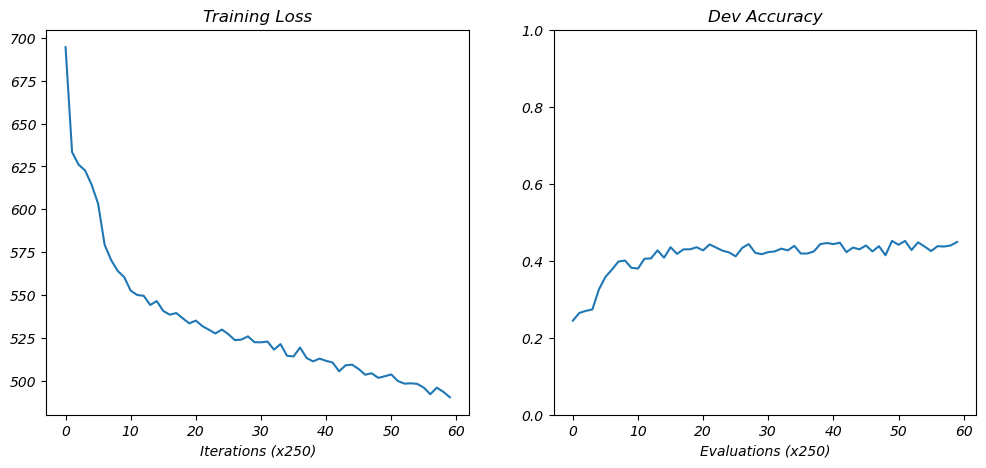

In [81]:
# plor the accuracies and losses in a nice way
import matplotlib.pyplot as plt
with open("treelstm_with_supervision_results.json", "r") as infile:
    results = json.load(infile)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(results["losses"])
plt.title("Training Loss")
plt.xlabel("Iterations (x250)")
plt.subplot(1,2,2)
plt.plot(results["accuracies"])
plt.title("Dev Accuracy")
plt.xlabel("Evaluations (x250)")
plt.ylim(0,1)
plt.show()
